[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SDPM-lab/rag-agent-course/blob/main/rag-agent-example.ipynb)


In [1]:
!pip install -q langchain langgraph gradio langchain-community faiss-cpu langchain-openai langchain-ollama pypdf

In [2]:
import os
import uuid
import gradio as gr
import faiss
import random
import time
from typing import Generator, Any, Literal
from datetime import datetime
from zoneinfo import ZoneInfo
from pydantic import BaseModel, Field
from langchain_community.utilities import SearxSearchWrapper
from langchain_core.documents import Document
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import END, START, StateGraph

# RAG Agent 問答流程圖

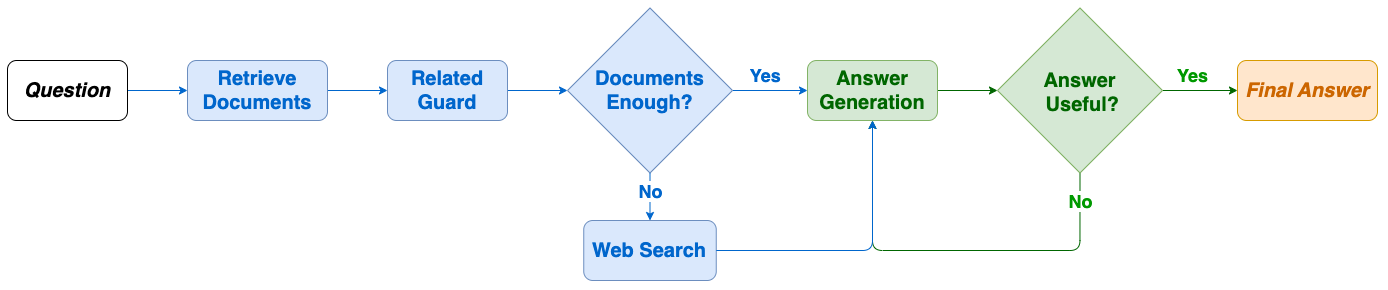

In [3]:
CHAT_MODEL = "gemma3:12b" # | "gemma3:12b" | "llama3.2:3b"
EMBED_MODEL = "all-minilm:22m"
SEARXNG_BASE_URL = "http://127.0.0.1:18080"
OLLAMA_BASE_URL = "http://localhost:11434"

# 佈署 SearXNG
- 提供 Agent 網路搜尋能力的基礎
- 使用方法 "http://127.0.0.1:18080/search?q={Query}&engines=google&format=json"

In [4]:
# 下載 SearXNG 專案
!git clone https://github.com/searxng/searxng.git

# 安裝 SearXNG
!pip install -qe ./searxng

# 安裝 SearXNG 依賴
!apt install -y libxslt-dev libffi-dev libxml2-dev libyaml-dev build-essential
!pip install -q gunicorn

# 設定回傳格式接受 html 與 json
!echo -e "\nsearch:\n  formats:\n    - html\n    - json" >> ./searxng/searx/settings.yml

# 啟動 SearXNG 監聽於 127.0.0.1:18080
!nohup bash -c 'cd ./searxng/ && export SEARXNG_SETTINGS_PATH=./searx/settings.yml && export SEARXNG_SECRET="tMvdyUB4C3a1EfAwn5Dd2VwFk9a-fK2yPx7Hb13wqLM9EvciB6C3uCuLJlnHjwkl6xOq5TcAYi5m7CSrP0DByA" && gunicorn searx.webapp:app --bind 127.0.0.1:18080' > ./searxng.log 2>&1 &


fatal: destination path 'searxng' already exists and is not an empty directory.
  Preparing metadata (setup.py) ... done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libxslt1-dev' instead of 'libxslt-dev'
build-essential is already the newest version (12.9ubuntu3).
libffi-dev is already the newest version (3.4.2-4).
libyaml-dev is already the newest version (0.2.2-1build2).
libxml2-dev is already the newest version (2.9.13+dfsg-1ubuntu0.7).
libxslt1-dev is already the newest version (1.1.34-4ubuntu0.22.04.4).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [5]:
# 測試 SearXNG
time.sleep(1)
!curl -H "Accept: application/json" "http://127.0.0.1:18080/search?q=agent&engines=google&format=json"

{"query": "agent", "number_of_results": 0, "results": [{"url": "https://dictionary.cambridge.org/dictionary/english/agent", "title": "AGENT | English meaning - Cambridge Dictionary", "content": "a person who acts for or represents another: Please contact our agent in Spain for further information. a person who represents an actor, artist, or writer.", "thumbnail": null, "engine": "google", "template": "default.html", "parsed_url": ["https", "dictionary.cambridge.org", "/dictionary/english/agent", "", "", ""], "img_src": "", "priority": "", "engines": ["google"], "positions": [1], "score": 1.0, "category": "general"}, {"url": "https://en.wikipedia.org/wiki/Agent_(film)", "title": "Agent (film)", "content": "Agent is a 2023 Indian Telugu-language spy action thriller film directed by Surender Reddy, from a story by Vakkantham Vamsi, and produced by Anil Sunkara", "thumbnail": null, "engine": "google", "template": "default.html", "parsed_url": ["https", "en.wikipedia.org", "/wiki/Agent_(fi

# 佈署 Ollama
- 為 LLM 推理任務分配 GPU 資源
- 提供執行 LLM 推理能力的基礎

In [6]:
# 下載與安裝 Ollama
!curl -fsSL https://ollama.com/install.sh | sh

# 啟動 Ollama serve 監聽於 127.0.0.1:11434
!nohup ollama serve > ./ollama.log 2>&1 &

# 拉取模型
!ollama pull $CHAT_MODEL
!ollama pull $EMBED_MODEL

>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.




In [7]:
# 測試 Chat Model
!curl {OLLAMA_BASE_URL}/api/generate \
-H "Content-Type: application/json" \
-d '{{"model":"{CHAT_MODEL}", "prompt":"Hello", "stream":false}}'

{"model":"gemma3:12b","created_at":"2025-07-17T03:22:49.792420849Z","response":"Hello there! 😊 \n\nIt's nice to hear from you. What can I do for you today?","done":true,"done_reason":"stop","context":[105,2364,107,9259,106,107,105,4368,107,9259,993,236888,103453,236743,108,1509,236789,236751,6290,531,6899,699,611,236761,2900,740,564,776,573,611,3124,236881],"total_duration":28175655001,"load_duration":26096691204,"prompt_eval_count":10,"prompt_eval_duration":808669056,"eval_count":24,"eval_duration":1269259553}

In [8]:
# 測試 Embed Model
!curl {OLLAMA_BASE_URL}/api/embed \
-H "Content-Type: application/json" \
-d '{{"model":"{EMBED_MODEL}", "input":"Hello"}}'

{"model":"all-minilm:22m","embeddings":[[-0.06271067,0.055202164,0.052067954,0.085662335,-0.0830618,-0.074663125,0.068721004,0.018301494,-0.08219705,-0.037278045,0.012222229,0.0036386,-0.004131251,-0.04392097,0.021772247,-0.0052733403,0.019769948,-0.042087257,-0.1103978,0.005260314,-0.05604539,0.027987737,-0.023098812,0.0287447,-0.053553104,-0.05246428,0.033581514,0.045083996,0.023923267,-0.0729976,0.054733783,0.016770607,0.081495866,-0.0030301875,0.011868502,0.07346212,-0.094074994,-0.08134726,0.039955404,0.0006588285,-0.013380966,-0.05455148,0.005114174,-0.026259203,0.036665324,-0.033981945,0.021306396,0.055883907,0.05776361,-0.0056336843,-0.06871587,-0.09008114,-0.043031495,0.023720143,0.12160131,0.03253241,-0.022722198,-0.02297437,0.048571233,-0.059308264,-0.034130942,0.03592587,-0.08108277,-0.02205041,0.013254186,-0.045743335,-0.07036864,-0.052561115,-0.04799133,-0.074784316,-0.028808659,0.0130431885,-0.042938896,0.005848046,-0.03910049,0.015788626,0.020262687,0.0053289495,0.00943

# 建立 Chat Model 與 Embed Mode 物件

In [9]:
from langchain_ollama import ChatOllama, OllamaEmbeddings

# 大語言模型
llm = ChatOllama(model=CHAT_MODEL, base_url=OLLAMA_BASE_URL)

# 嵌入模型
embed = OllamaEmbeddings(model=EMBED_MODEL, base_url=OLLAMA_BASE_URL)

# 初始化 FAISS 向量資料庫

In [10]:
import faiss
from langchain_community.vectorstores import FAISS
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.document_loaders import TextLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# 文本分塊器
text_spliter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, # 每 1000 tokens 為一個 chunk
    chunk_overlap=200, # 每個 chunk 之間重疊 200 tokens
)

# 將知識文件嵌入到向量資料庫中
def update_rag_docs(vector_store, file_paths: list[str]) -> None:
    for file_path in file_paths:
        file_name = file_path.split("/")[-1]
        try:
            # 文件讀取
            if file_path.lower().endswith(".txt") or file_path.lower().endswith(".md"):
                loader = TextLoader(file_path)
            elif file_path.lower().endswith(".pdf"):
                loader = PyPDFLoader(file_path)
            else:
                continue  # Skip unsupported file types
            documents = loader.load()

            # 知識切分
            chunks = text_spliter.split_documents(documents)

            # 知識嵌入
            uuids = [str(uuid.uuid4()) for _ in range(len(chunks))]
            vector_store.add_documents(documents=chunks, ids=uuids, matedate={"file_name": file_name})
        except Exception as e:
            return f"Error: {e}"


# 創建向量資料庫
def create_vector_store(file_paths: list[str]) -> FAISS:
    vector_store = FAISS(
        embedding_function=embed, # 指定使用的 Embed Model
        index=faiss.IndexFlatL2(len(embed.embed_query("index"))),
        docstore=InMemoryDocstore(),
        index_to_docstore_id={},
    )
    update_rag_docs(vector_store, file_paths)
    return vector_store


# 使用 LangChain 搭建 RAG Agent 應用

In [11]:
class GraphState(BaseModel):
    question: str # User question
    vector_store: Any

    retrieve_query: str = "" # Query for retrieving documents
    web_search_query: str = "" # Query for web search
    documents: list[Document] = Field(default_factory=list) # List of retrieved documents
    max_reference_documents: int = 5 # Maximum number of documents to retrieve

    answer: str = "" # Final answer
    explanation: str = "" # Useful explanation
    retry: bool = False # Answer Regenerate Control
    max_retries: int = 5 # Maximum number of answer to generated

## 建立工具函數

In [12]:
# 獲取當前系統環境資訊
ENRVIRONMENT_TEMPLATE = """\
當前環境資訊:

# 對話語系:
台灣

# 當前時間:
{time_info}
"""
def get_environment() -> str:
    tz = ZoneInfo("Asia/Taipei")
    now = datetime.now(tz)
    formatted_time = now.strftime("%Y/%m/%d, %H:%M:%S, UTC %z")
    return ENRVIRONMENT_TEMPLATE.format(time_info=formatted_time)


# 網路搜尋工具
searxng_search = SearxSearchWrapper(searx_host=SEARXNG_BASE_URL)
@tool
def search_tool(query: str, k: int=5) -> list[Document]:
    """web search tool"""
    try:
        results = searxng_search.results(
            query,
            num_results=k,
            language="zh-TW",
            engines=["google", "wiki"],
        )
    except Exception as e:
        results = []
        print(f"Error web search: {e}")
    documents = [
        Document(
            page_content=result["snippet"],
            metadata={
                "title": result["title"],
                "link": result["link"],
                "engines": result["engines"],
                "category": result["category"]
            }
        )
        for result in results
    ]
    return documents


# RAG 檢索工具
@tool
def retrieve_tool(vector_store: FAISS ,query: str, k: int = 5) -> list[Document]:
    """documents retrieve tool"""
    docs = vector_store.similarity_search(query, k=k)
    text_set = set()
    filtered_docs = []
    for doc in docs:
        if doc.page_content in text_set:
            continue
        text_set.add(doc.page_content)
        filtered_docs.append(doc)
    return filtered_docs[:k]



## 建立工作節點

### 知識文件檢索節點
負責從知識庫中檢索出問題相關的知識文件

In [13]:
# 知識文件檢索節點
RETRIEVE_QUERY_INSTRUCTION = """\
你是一位專業的知識檢索助手，負責協助將使用者的自然語言問題轉換為一組最適合文件查找的檢索關鍵詞。

請遵循以下原則來擬定檢索關鍵詞：
1. 僅保留具有語義意涵的「主題名詞」、「重要技術詞彙」、「關鍵概念」。
2. 移除無意義的助詞、疑問詞、冗長動詞（如「如何實作」、「要不要」、「什麼是」）。
3. 以「繁體中文關鍵詞」為主，必要時可補充英文術語。
4. 多個關鍵詞請以英文逗號（,）分隔。

# 範例
問題：如何設計具補償機制的分散式交易流程，並結合 Saga 模式？\
檢索關鍵詞：分散式交易, 補償機制, Saga 模式, 微服務, 交易一致性

問題：用 Python 實作 YOLOv8 做小物件瑕疵偵測的最佳做法是什麼？\
檢索關鍵詞：Python, YOLOv8, 小物件偵測, 瑕疵檢測, 實作方法

問題：什麼是 BERT 模型的 attention 機制？\
檢索關鍵詞：BERT, attention 機制, 自注意力
"""

RETRIEVE_QUERY_PROMPT_TEMPLATE = """\
使用者問題：
{question}
"""

RETRIEVE_QUERY_CHAT_TEMPLATE = ChatPromptTemplate([
        ("system", RETRIEVE_QUERY_INSTRUCTION),
        ("human", RETRIEVE_QUERY_PROMPT_TEMPLATE),
        ("human", "{environment}"),
])

class RetrieveQueryOutput(BaseModel):
    query: str = Field(
        description="檢索關鍵詞"
    )

def retrieve_documents(state: GraphState):
    question = state.question
    vector_store = state.vector_store
    max_reference_documents = state.max_reference_documents

    # 生成檢索關鍵詞
    llm_with_struct = llm.with_structured_output(RetrieveQueryOutput)
    environment = get_environment()
    messages = RETRIEVE_QUERY_CHAT_TEMPLATE.invoke({
        "question": question,
        "environment": environment,
    }).to_messages()
    answer = llm_with_struct.invoke(messages)
    # 根據關鍵詞檢所本地知識庫
    retrieved_documents = retrieve_tool.invoke({"vector_store": vector_store, "query": answer.query, "k": max_reference_documents})
    return {"documents": retrieved_documents, "retrieve_query": answer.query}



### 知識文件守衛節點
負責檢查檢索出的知識文件是否對回答問題有幫助

In [14]:
# 知識文件守衛節點
RELATED_GUARD_INSTRUCTION = """\
你是一位專業的知識評估員，負責判斷一段文件內容是否對回答問題有所幫助。

評估準則：
1. 是否有助於用來回答問題（即使不是完整答案）？

若符合上述任何條件，請視為「相關」。
"""

RELATED_GUARD_PROMPT_TEMPLATE = """\
# 文件內容：
{document}

# 問題：
{question}
"""

RELATED_GUARD_CHAT_TEMPLATE = ChatPromptTemplate([
        ("system", RELATED_GUARD_INSTRUCTION),
        ("human", RELATED_GUARD_PROMPT_TEMPLATE),
        ("human", "{environment}"),
])

class RelatedGuardOutput(BaseModel):
    related: Literal["yes", "no"] = Field(
        description="是否相關"
    )

def related_guard(state: GraphState):
    question = state.question
    documents = state.documents

    llm_with_struct = llm.with_structured_output(RelatedGuardOutput)
    environment = get_environment()
    filtered_docs = []
    for doc in documents:
        # 檢查檢索結果是否與問題相關
        messages = RELATED_GUARD_CHAT_TEMPLATE.invoke({
            "document": doc,
            "question": question,
            "environment": environment,
        }).to_messages()
        anser = llm_with_struct.invoke(messages)
        # 加入至候選參考知識文件中
        if anser.related.lower() == "yes":
            filtered_docs.append(doc)

    return {"documents": filtered_docs}


### 網路查詢節點
負責從網路中查詢與問題相關的知識

In [15]:
# 網路查詢節點
WEB_SEARCH_QUERY_INSTRUCTION = """\
你是一位專業的網路搜尋助手，負責根據問題，擬定一個適合送出到搜尋引擎（如 Google）的中文查詢語句。

請遵守以下原則：
1. 查詢語句應簡潔明確，保留核心關鍵詞與語意重點。
2. 排除冗詞（如「請問」、「幫我查一下」等），使用搜尋引擎慣用的簡明語法。
3. 若有具體主題、技術、年份、地點，可酌情加入以提升準確度。

# 範例
問題：什麼是 LoRA 微調？\
查詢語句：LoRA 微調 是什麼

問題：2024 年有哪些生成式 AI 應用趨勢？\
查詢語句：2024 生成式 AI 趨勢

問題：如何用 Python 抓取網頁資料？\
查詢語句：Python 網頁爬蟲 教學
"""

WEB_SEARCH_QUERY_PROMPT_TEMPLATE = """\
問題:
{question}
"""

WEB_SEARCH_QUERY_CHAT_TEMPLATE = ChatPromptTemplate([
        ("system", WEB_SEARCH_QUERY_INSTRUCTION),
        ("human", WEB_SEARCH_QUERY_PROMPT_TEMPLATE),
        ("human", "{environment}"),
])

class WebSearchQueryOutput(BaseModel):
    query: str = Field(
        description="查詢語句"
    )

def web_search(state: GraphState):
    question = state.question
    documents = state.documents
    max_reference_documents = state.max_reference_documents

    # 檢查先前檢所的私有文件是否已滿足參考文件數量
    documents_len = len(documents)
    if documents_len >= max_reference_documents:
        return {}
    # 生成網路搜尋查詢語句
    llm_with_struct = llm.with_structured_output(WebSearchQueryOutput)
    environment = get_environment()
    messages = WEB_SEARCH_QUERY_CHAT_TEMPLATE.invoke({
        "question": question,
        "environment": environment,
    }).to_messages()
    answer = llm_with_struct.invoke(messages)
    # 根據查詢語句進行網路搜尋
    search_docs = search_tool.invoke({"query": answer.query, "k": max_reference_documents - documents_len})
    documents.extend(search_docs)
    return {"documents": documents, "web_search_query": answer.query}

### 回答生成節點
負責根據知識文件來生成問題的答覆

In [16]:
# 回答生成節點
ANSWER_GENERATION_INSTRUCTION = """\
你是一位專業的問答助手，負責根據提供的「參考資料」來回答問題。

請遵守以下原則：
1. 僅根據參考資料內容作答，禁止編造未出現的資訊。
2. 若資料不足，請明確回覆「查無相關資料」。
3. 回答要簡潔、明確，避免冗言贅語。
"""

ANSWER_GENERATION_PROMPT_TEMPLATE = """\
# 前次回答（若有）：
{prev_answer}

# 對於前次回答的修改建議（若有）：
{prev_answer_suggestion}

# 參考資料：
{context}

# 問題：
{question}

# 回答：
"""

ANSWER_GENERATION_CHAT_TEMPLATE = ChatPromptTemplate([
        ("system", ANSWER_GENERATION_INSTRUCTION),
        ("human", ANSWER_GENERATION_PROMPT_TEMPLATE),
        ("human", "{environment}"),
])

def answer_generation(state: GraphState):
    question = state.question
    documents = state.documents
    prev_answer = state.answer
    prev_answer_suggestion = state.explanation
    max_retries = state.max_retries

    # 將檢索結果整理為參考資料格式
    doc_texts = []
    for doc in documents:
        doc_from = "web" if "link" in doc.metadata else "local"
        doc_texts.append(f"Document(from={doc_from}, text={doc.page_content})")
    context = "\n".join(doc_texts)
    # 生成回答
    environment = get_environment()
    messages = ANSWER_GENERATION_CHAT_TEMPLATE.invoke({
        "prev_answer": prev_answer,
        "prev_answer_suggestion": prev_answer_suggestion,
        "context": context,
        "question": question,
        "environment": environment,
    }).to_messages()
    answer = llm.invoke(messages).content
    return {
        "max_retries": max_retries - 1,
        "answer": answer,
    }

### 答覆檢查節點
確保最終答覆正確且有效的回答了問題

In [17]:
ANSWER_GUARD_INSTRUCTION = """\
你是一位正在批改測驗的老師，你將得到一個問題和一個學生的答案。

以下是需要遵循的評判標準：
1. 學生的回答有正確回答了問題

評判結果：
- 結果為 "yes" 表示學生的答案符合所有標準。這是您能給的最高分數。如果學生的答案在滿足問題的情況下額外又給出了其他說明，則他能夠獲得 "yes"。
- 結果為 "no" 表示學生的答案不符合所有標準。這是您能給的最低分數。

逐步解釋你的推理，以確保你的推理和結論是正確的。
避免一開始就簡單陳述正確答案。
"""

ANSWER_GUARD_PROMPT_TEMPLATE = """\
問題:
{question}

學生回答:
{answer}
"""

ANSWER_GUARD_CHAT_TEMPLATE = ChatPromptTemplate([
        ("system", ANSWER_GUARD_INSTRUCTION),
        ("human", ANSWER_GUARD_PROMPT_TEMPLATE),
])

class AnswerGuardOutput(BaseModel):
    useful: Literal["yes", "no"] = Field(
        description="對學生答案的評判結果"
    )
    explanation: str = Field(
        description="對評判結果的解釋"
    )

def answer_guard(state: GraphState):
    question = state.question
    answer = state.answer

    llm_with_struct = llm.with_structured_output(AnswerGuardOutput)
    messages = ANSWER_GUARD_CHAT_TEMPLATE.invoke({
        "answer": answer,
        "question": question,
    }).to_messages()
    result = llm_with_struct.invoke(messages)
    explanation = result.explanation
    if result.useful.lower() == "yes":
        return {"retry": False, "explanation": explanation}
    else:
        return {"retry": True, "explanation": explanation}

def answer_guard_router(state: GraphState):
    retry = state.retry
    max_retries = state.max_retries
    if max_retries <= 0:
        return END
    if retry:
        return "regenerate"
    else:
        return END


### 參考知識文件檢索路由
負責檢查是否已提供足夠的參考資料，不夠則使用搜尋引擎補足

In [18]:
# 參考知識文件檢查節點
def documents_router(state: GraphState):
    documents = state.documents
    max_reference_documents = state.max_reference_documents
    if len(documents) < max_reference_documents:
        return "not_enough"
    else:
        return "enough"

### 答案重生成路由
負責檢查生成結果是否被判定為需要重新生成，以及確保最大重生成次數限制

In [19]:
def answer_guard_router(state: GraphState):
    retry = state.retry
    max_retries = state.max_retries
    if max_retries <= 0:
        return END
    if retry:
        return "regenerate"
    else:
        return END

## 建立工作流

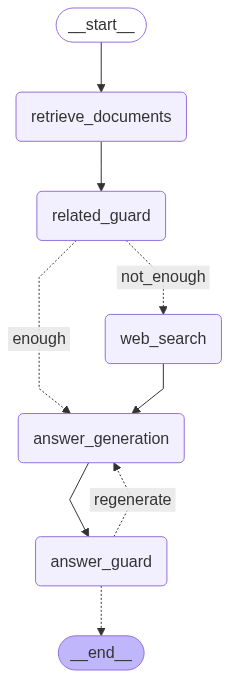

In [20]:
from IPython.display import Image, display

# 建立工作流
def create_graph():
    workflow = StateGraph(GraphState)

    # Define the nodes
    workflow.add_node("retrieve_documents", retrieve_documents)
    workflow.add_node("related_guard", related_guard)
    workflow.add_node("web_search", web_search)
    workflow.add_node("answer_generation", answer_generation)
    workflow.add_node("answer_guard", answer_guard)

    # Build graph
    workflow.add_edge(
        START,
        "retrieve_documents"
    )
    workflow.add_edge(
        "retrieve_documents",
        "related_guard"
    )
    # 條件邊：檢索結果是否足夠
    workflow.add_conditional_edges(
        "related_guard",
        documents_router,
        {
            "enough": "answer_generation",
            "not_enough": "web_search",
        },
    )
    workflow.add_edge(
        "web_search",
        "answer_generation"
    )
    workflow.add_edge(
        "answer_generation",
        "answer_guard"
    )
    # 條件邊：回答是否滿足要求
    workflow.add_conditional_edges(
        "answer_guard",
        answer_guard_router,
        {
            "regenerate": "answer_generation",
            END: END,
        },
    )

    # Compile
    graph = workflow.compile()
    return graph

graph = create_graph()
display(Image(graph.get_graph().draw_mermaid_png()))

## 測試 Agent 工作流程

In [21]:
# 啟動 SearXNG 監聽於 127.0.0.1:18080
!nohup bash -c 'cd ./searxng/ && export SEARXNG_SETTINGS_PATH=./searx/settings.yml && export SEARXNG_SECRET="tMvdyUB4C3a1EfAwn5Dd2VwFk9a-fK2yPx7Hb13wqLM9EvciB6C3uCuLJlnHjwkl6xOq5TcAYi5m7CSrP0DByA" && gunicorn searx.webapp:app --bind 127.0.0.1:18080' > ./searxng.log 2>&1 &

# 啟動 Ollama serve 監聽於 127.0.0.1:11434
!nohup ollama serve > ./ollama.log 2>&1 &

# 測試 agent
for event in graph.stream({"question": "高雄天氣", "vector_store": create_vector_store([])}, stream_mode="debug"):
    print(event)

{'step': 1, 'timestamp': '2025-07-17T03:22:52.049083+00:00', 'type': 'task', 'payload': {'id': '474db75b-cc4d-6813-421e-b862aa77efb7', 'name': 'retrieve_documents', 'input': GraphState(question='高雄天氣', vector_store=<langchain_community.vectorstores.faiss.FAISS object at 0x7b4b25a44950>, retrieve_query='', web_search_query='', documents=[], max_reference_documents=5, answer='', explanation='', retry=False, max_retries=5), 'triggers': ('branch:to:retrieve_documents',)}}
{'step': 1, 'timestamp': '2025-07-17T03:22:53.947871+00:00', 'type': 'task_result', 'payload': {'id': '474db75b-cc4d-6813-421e-b862aa77efb7', 'name': 'retrieve_documents', 'error': None, 'result': [('documents', []), ('retrieve_query', '高雄, 天氣')], 'interrupts': []}}
{'step': 2, 'timestamp': '2025-07-17T03:22:53.948259+00:00', 'type': 'task', 'payload': {'id': '45d2f46a-478b-e562-68d0-fba3f226a8eb', 'name': 'related_guard', 'input': GraphState(question='高雄天氣', vector_store=<langchain_community.vectorstores.faiss.FAISS obje

# 使用 Gradio 搭建 Web UI

In [ ]:
# 啟動 SearXNG 監聽於 127.0.0.1:18080
!nohup bash -c 'cd ./searxng/ && export SEARXNG_SETTINGS_PATH=./searx/settings.yml && export SEARXNG_SECRET="tMvdyUB4C3a1EfAwn5Dd2VwFk9a-fK2yPx7Hb13wqLM9EvciB6C3uCuLJlnHjwkl6xOq5TcAYi5m7CSrP0DByA" && gunicorn searx.webapp:app --bind 127.0.0.1:18080' > ./searxng.log 2>&1 &

# 啟動 Ollama serve 監聽於 127.0.0.1:11434
!nohup ollama serve > ./ollama.log 2>&1 &

def run_agent(vector_store: FAISS, question: str) -> Generator[tuple[str, str], Any, None]:
    inputs = {
        "question": question,
        "vector_store": vector_store,
        "max_reference_documents": 5,
    }

    docs_tracked = False
    debug_trace = "\n\n===== Trace Start =====\n\n"
    final_answer = ""
    for event in graph.stream(inputs, stream_mode="debug"):
        event_type = event["type"]
        payload = event["payload"]
        node_name = payload["name"]
        node_title = node_name.replace("_", " ").title()

        if event_type == "task":
            state = payload["input"].model_dump()

            # 追蹤 Agent 的參考文件
            if node_name == "answer_generation" and not docs_tracked:
                docs_tracked = True
                documents = state["documents"]

                doc_texts = []
                for i, doc in enumerate(documents):
                    source_from = "web" if "link" in doc.get("metadata") else "local"
                    doc_texts.append(f"{i+1}. Document(from={source_from}, text={doc.get('page_content', '')})")

                context = '\n\n'.join(doc_texts)
                debug_trace += f"\n\n@ Documents:\n{context}"


        elif event_type == "task_result":
            state = {k:v for k, v in payload["result"]}

            if node_name == "retrieve_documents":
                query = state["retrieve_query"]
                debug_trace += f"\n\n@ {node_title}\n"
                debug_trace += f"Query:\n{query}\n"

            if node_name == "web_search":
                query = state["web_search_query"]
                debug_trace += f"\n\n@ {node_title}\n"
                debug_trace += f"Query:\n{query}\n"

            # 追蹤 Agent 的回答生成
            if node_name == "answer_generation":
                answer = state["answer"]
                debug_trace += f"\n\n@ {node_title}\n"
                debug_trace += f"Answer:\n{answer}\n"
                final_answer = answer

            # 追蹤 Agent 的回答檢查
            if node_name == "answer_guard":
                retry = state["retry"]
                explanation = state["explanation"]
                debug_trace += f"\n\n@ {node_title}\n"
                debug_trace += f"Retry: {retry}\n"
                debug_trace += f"Explanation:\n{explanation}\n"
                final_answer = answer

        yield final_answer, debug_trace

    debug_trace += "\n\n===== Trace End =====\n\n"
    yield final_answer, debug_trace

def get_random_question() -> str:
    questions = [
        "今天高雄天氣如何？",
        "目前新台幣對美元匯率是多少？",
    ]
    return random.choice(questions)

# Gradio Interface setup
with gr.Blocks(title="RAG Agent Demo") as demo:
    with gr.Row():
        with gr.Column(scale=2):
            gr.Markdown(f"# RAG Agent Interface\nRAG Agent 是一款結合大型語言模型(LLM)與檢索增強生成(RAG)的智慧代理，具備網路搜尋、知識檢索與答案優化能力。")
        with gr.Column(scale=1):
            gr.HTML("""
                <a href="https://github.com/SDPM-lab/rag-agent-course/tree/main" target="_blank" style="text-decoration: none;">
                    <button style="
                        background-color: #24292e;
                        color: white;
                        width: 100%;
                        padding: 10px 20px;
                        font-size: 16px;
                        border: none;
                        border-radius: 5px;
                        cursor: pointer;
                    ">
                        🔗 View on GitHub
                    </button>
                </a>
            """)
    with gr.Row():
        with gr.Column(scale=2):
            gr.Markdown("## Agent Chat")
            final_answer = gr.Textbox(show_label=True, label="Final Answer", interactive=False)
            trace_chatbot = gr.Chatbot(label="Agent Trace", type="messages")
            question_input = gr.Textbox(show_label=True, label="Question", placeholder="Enter your question...", value=get_random_question())

        with gr.Column(scale=1):
            gr.Markdown("## Knowledge Files")
            file_upload = gr.File(label="Upload Knowledge Documents (.pdf, .txt, .md)", file_count="multiple", type="filepath")

    def on_question_input_submit(question: str, history: list[dict]) -> tuple[str, list[dict]]:
        return get_random_question(), [{"role": "user", "content": question}]

    def answer_generator(file_paths: list[str] | None, history: list[dict]) -> Generator[tuple[str, list[dict]], None, None]:
        file_paths =  [] if file_paths is None else file_paths
        vector_store = create_vector_store(file_paths)
        question = history[0]["content"]
        history.append({"role": "assistant", "content": ""})
        for final_ans, debug_trace in run_agent(vector_store, question):
            history[-1]['content'] = debug_trace
            final_ans = final_ans
            yield "", history

        history[-1]['content'] += f"\n@ Final Answer:\n{final_ans}\n"
        yield final_ans, history

    question_input.submit(
        on_question_input_submit,
        inputs=[question_input, trace_chatbot],
        outputs=[question_input, trace_chatbot],
        queue=False,
    ).then(
        answer_generator,
        inputs=[file_upload, trace_chatbot],
        outputs=[final_answer, trace_chatbot],
    )

demo.launch(share=True, debug=False)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://12bfd8c4cd515b6c68.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
